Построить классификатор изображений рукописного ввода на базе MNIST.

В качестве модели классификатора можно использовать любую известную модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

In [ ]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [ ]:
train_label = train[:, 0]
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [ ]:
test_label = test[:, 0]

In [ ]:
train_img.shape

(42000, 28, 28)

In [ ]:
test_img.shape

(28000, 28, 28)

## Визуализирую исходные данные

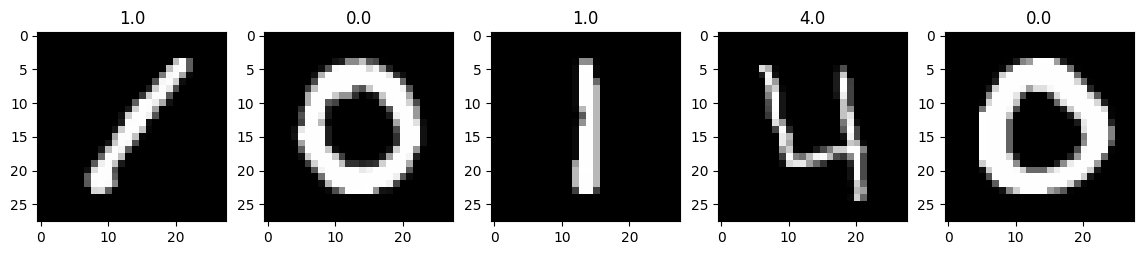

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Задаю параметры для вычисления дескриптора HOG

In [ ]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

## Вычисляю дескриптор для изображения

In [ ]:
descriptor = hog.compute(np.uint8(train_img[0]))
print('Descriptor size: %d' % len(descriptor))

Descriptor size: 144


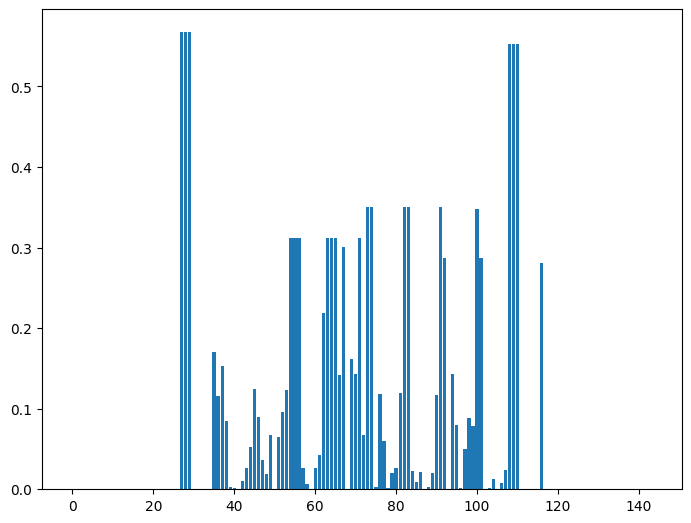

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(descriptor)), descriptor.reshape(-1))
plt.show()

In [ ]:
#Создам тренировочный и тестовый массивы с гистограммами градиентов для каждого изображения с цифрой
train_hog_list = []

for i in range(len(train_img)):
  train_hog_list.append(hog.compute(np.uint8(train_img[i])))

train_hog_array = np.array(train_hog_list)

In [ ]:
test_hog_list = []

for i in range(len(test_img)):
  test_hog_list.append(hog.compute(np.uint8(test_img[i])))

test_hog_array = np.array(test_hog_list)

## Нормирую вектор гистограммы

In [ ]:
train_hog_array = train_hog_array / np.linalg.norm(train_hog_array, axis=1)[:, None]

In [ ]:
test_hog_array = test_hog_array / np.linalg.norm(test_hog_array, axis=1)[:, None]

## Разбиваю тренировочную выборку на обучение и валидацию

In [ ]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hog_array, test_size=0.2,
    random_state=42)

## Обучаю модель классификации случайного леса и оцениваю качество предсказаний

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
rfc = RandomForestClassifier().fit(x_train, y_train)

In [ ]:
y_pred_val = rfc.predict(x_val)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
print('Accuracy: %s' % accuracy_score(y_val, y_pred_val))

Accuracy: 0.9683333333333334


In [ ]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       816
         1.0       0.99      0.99      0.99       909
         2.0       0.96      0.98      0.97       846
         3.0       0.97      0.96      0.96       937
         4.0       0.98      0.97      0.97       839
         5.0       0.98      0.96      0.97       702
         6.0       0.97      0.99      0.98       785
         7.0       0.96      0.96      0.96       893
         8.0       0.96      0.95      0.96       835
         9.0       0.95      0.95      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [ ]:
print(confusion_matrix(y_val, y_pred_val))

[[806   1   1   1   1   0   4   1   1   0]
 [  0 897   5   1   2   0   1   2   0   1]
 [  3   3 826   7   1   0   0   2   4   0]
 [  3   0   6 898   0   9   0   5  11   5]
 [  0   0   2   0 811   0   4   7   1  14]
 [  1   0   1  10   3 673   7   3   3   1]
 [  3   1   1   0   0   2 775   0   3   0]
 [  0   1  10   2   4   0   0 856   2  18]
 [  8   1   7   3   3   5   6   3 794   5]
 [  3   2   5   6   5   0   0  15   4 798]]


## Предсказания на тестовых данных

In [ ]:
y_pred_test = rfc.predict(test_hog_array)

In [ ]:
#ЗДЕСЬ ЧТО-ТО НЕ ТО, ПРЕДСКАЗАНИЯ ВЕРНЫЕ, ЭТО ВИДНО НА ГРАФИКЕ

In [ ]:
print('Accuracy: %s' % accuracy_score(test_label, y_pred_test))

Accuracy: 0.09992857142857142


In [ ]:
print(classification_report(test_label, y_pred_test))

              precision    recall  f1-score   support

         0.0       1.00      0.10      0.18     28000
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00         0

    accuracy                           0.10     28000
   macro avg       0.10      0.01      0.02     28000
weighted avg       1.00      0.10      0.18     28000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(confusion_matrix(test_label, y_pred_test))

[[2798 3172 2878 2821 2783 2486 2744 2862 2722 2734]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


## Визуализирую предсказания

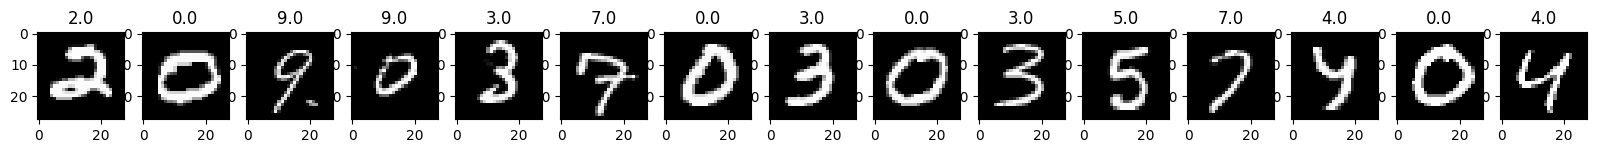

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:15], 1):
    subplot = fig.add_subplot(1, 15, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_pred_test[i - 1]);

## Подготовлю файл для отправки на Kaggle

In [ ]:
import csv

In [ ]:
with open('submit.csv', mode = 'w', encoding = 'utf-8') as dst:
  file_writer = csv.writer(dst, delimiter = ',', lineterminator="\r")
  file_writer.writerow(["ImageId", "Label"])


  for i, p in enumerate(y_pred_test, 1):
    file_writer.writerow([i, int(p)])
        #dst.write('%s,%s\n' % (i, p))

## Результат с Kaggle

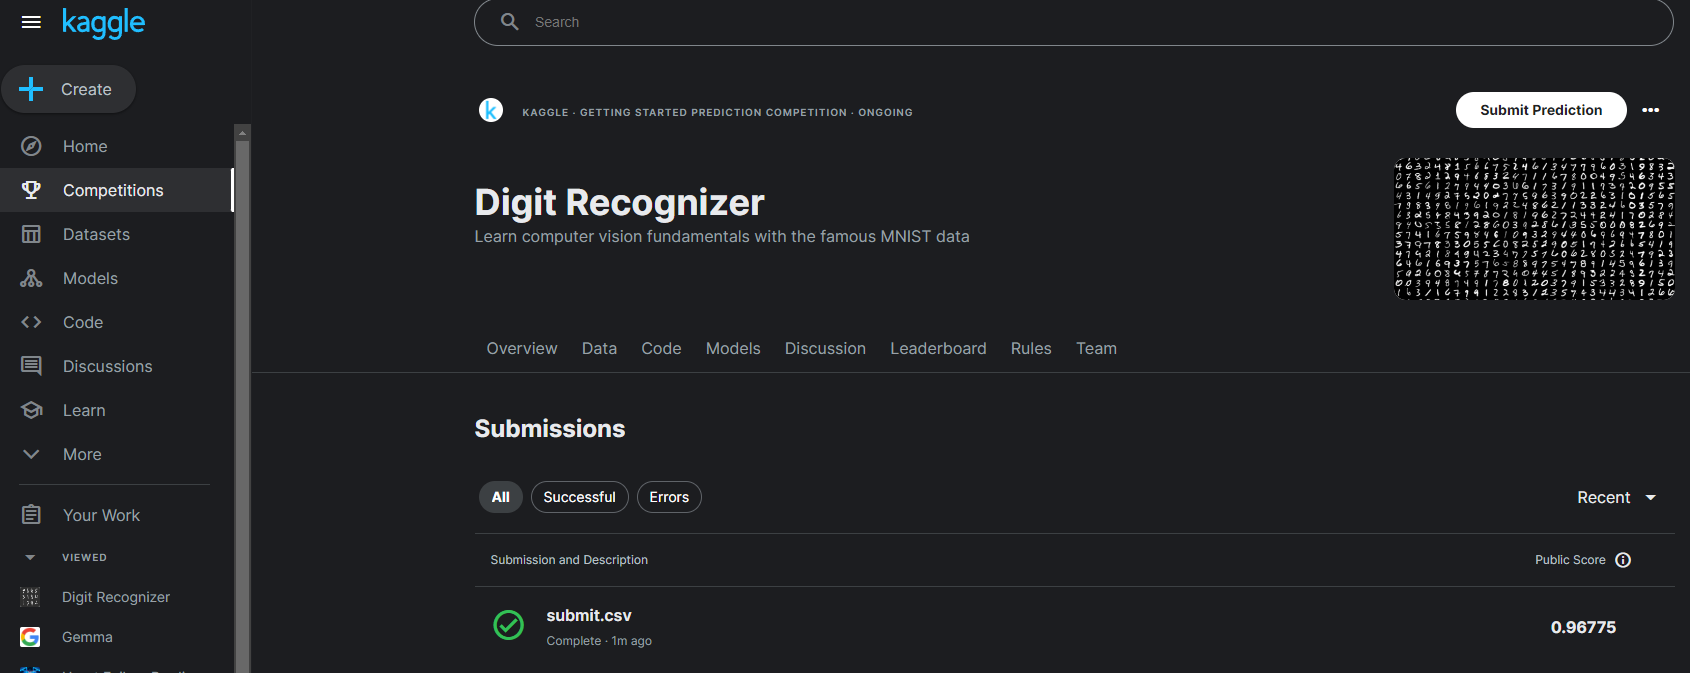

In [ ]:
#submit.csv Complete · 8m ago Score: 0.96775